In [44]:
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
from pickle import load
from IPython.display import display, clear_output
import warnings
import os
from random import sample
import imageio
import numpy as np

warnings.filterwarnings("ignore")

#path = "C:/Users/a.rojasa55/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Data/"
path = os.getcwd()
cd = 0.041
cw = 0.0388

In [45]:
stations = pd.read_csv(path+"/Definite Stations.csv",index_col=[0])
vehicles = pd.read_csv(path+"/Definite Vehicles.csv",index_col=[0])
locations = pd.read_csv(path+"/Definite Locations.csv",index_col=[0])

In [46]:
K = {}; K_s = {}
for sc in range(25):
    file = open(path+f"/K/K_sc{sc}","rb")
    K[sc] = load(file); file.close()

    file = open(path+f"/K_s10/Ks_sc{sc}","rb")
    K_s[sc] = load(file); file.close()

max_stress = max([len(K_s[sc][s]) for sc in range(sc) for s in stations.index]); min_stress = 0

In [47]:
def plot_scenario(sc=0,show_vehic=True,show_size=True,show_stat=True,show_stressed=True,random_stats=False,opt_stats = None):
        img = plt.imread("C:/Users/ari_r/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Problem Visualization/Population grey.PNG")
        
        fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))

        if show_vehic:
                locs = [l for l in locations.index if locations.loc[l,f"going {sc}"]>0]
                if show_size: szs = [15+12*locations.loc[l,f"going {sc}"] for l in locs]
                else: szs = [20 for l in locs]
                ax.scatter(locations["0"][locs],locations["1"][locs],s=szs,color="navy",alpha=0.5)
        
        if show_stat:
            stats = [s for s in stations.index if len(K_s[sc][s])>0]
            if show_stressed:
                cm = plt.get_cmap("gist_heat")
                for i in range(401):
                    ax.bar(x=-25,height=0.1875,width=5,bottom=37.5+0.1875*i,color=cm((1-i/400)*0.9))
                for i in range(6):
                    ax.text(x=-20,y=37.5+75*i/5,s=int((max_stress-min_stress)*i/5),va="center",ha="left",fontsize=14)
                ax.text(x=-30,y=75,rotation=90,s="stations stress index", fontsize = 14, va="center",ha="center", fontname="Century Gothic")
                cols = [cm((1-len(K_s[sc][s])/max_stress)*0.9) for s in stats]
            else:
                cols = ["darkorange" for s in stats]
            ax.scatter(stations["0"][stats],stations["1"][stats],c=cols)
        
        if random_stats:
             samp_stats = sample(list(stations.index),300)
             ax.scatter(stations["0"][samp_stats],stations["1"][samp_stats],c="yellowgreen")
            
        if opt_stats is not None:
            for s in stations.index:
                if s not in opt_stats:
                    if len(K_s[sc][s]) > 0:
                        ax.plot(stations.loc[s,"0"],stations.loc[s,"1"],color="red",linestyle="",marker="o")
                else:
                    ax.plot(stations.loc[s,"0"],stations.loc[s,"1"],color="deepskyblue",linestyle="",marker="o",markersize=7)
                 

        ax.vlines(x=[0,290],ymin=0,ymax=150,color="black")
        ax.hlines(y=[0,150],xmin=0,xmax=290,color="black")

        ax.spines[["top","bottom","left","right"]].set_visible(False)

        zero = (-5,-12)
        height = 184.425
        ax.imshow(img, extent=[zero[0], zero[0]+height*5/3, zero[1], zero[1]+height])
        
        ax.set_xlim(-40,320)
        ax.set_ylim(-20,170)
        ax.set_xticks([]); ax.set_yticks([])
        if not random_stats:
            ax.set_title(f"\nScenario {sc}\nNumber of vehicles: {len(K[sc])}",fontsize=18,fontname="Century Gothic")
        else:
            plt.savefig(path+f"/Sample Configs toy/Random_{sc}",dpi=300,transparent=True)

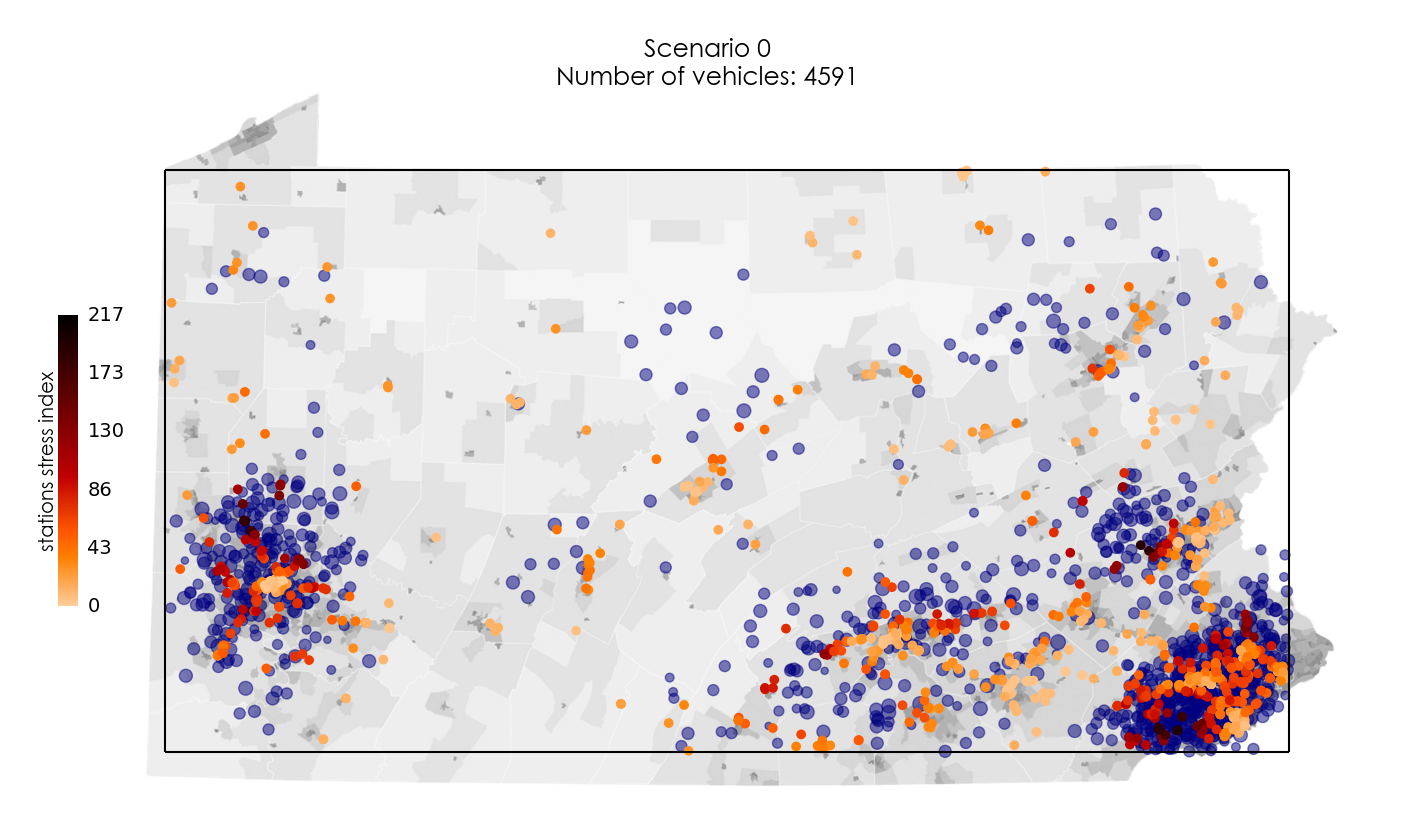

In [48]:
plot_scenario(0,show_vehic=True,show_size=True,show_stat=True,show_stressed=True,random_stats=False)

In [49]:
file = open("C:/Users/ari_r/OneDrive - Universidad de los Andes/Documentos/MOPTA-23/Results/Optimal/S","rb"); S = load(file); file.close()

In [50]:
images = []
for sc in range(10):
    images.append(imageio.imread(path+f"/Sample Configs toy/Random_{sc}.png"))


imageio.mimsave(path+'/Sample Configs toy.gif', images,duration=1)

FileNotFoundError: No such file: 'c:\Users\ari_r\OneDrive - Universidad de los Andes\Documentos\MOPTA-23\Data\Sample Configs toy\Random_0.png'

In [53]:
a = widgets.IntSlider(min=0,max=24,value=0,description='Scenario:',disabled=False,continuous_update=False,readout=True)
b = widgets.Checkbox(value=False,description="Vehicles",fontsize=18); c = widgets.Checkbox(value=False,description="Number of vehicles")
d = widgets.Checkbox(value=False,description="Stations"); e = widgets.Checkbox(value=False,description="Stations stress index")
ui = widgets.HBox([a, b, c, d, e])
def f(a, b, c, d, e):
    plot_scenario(sc=a,show_vehic=b,show_size=c,show_stat=d,show_stressed=e)

out = widgets.interactive_output(f, {"a": a, "b": b, "c": c, "d": d, "e": e})


In [54]:
display(ui, out)


Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1800x1200 with 1 Axes>', …

In [18]:
stress = {s:{sc:len(K_s[sc][s]) for sc in range(25)} for s in stations.index}
mean_stress = {s:np.mean([stress[s][sc] for sc in range(25)]) for s in stations.index}
sorted_stations = [s for s in sorted(mean_stress, key=mean_stress.get, reverse=True)]

In [42]:
print("\n")

print("S   ","Mean","Min","Max","SD   ","SD(%)",sep="\t")
print("-----------------------------------------------")
for s in sorted_stations:
    std = np.std(list(stress[s].values()),ddof=1)
    print(str(s)+"   "[:max(0,5-len(str(s)))],round(mean_stress[s],2),min(stress[s].values()),max(stress[s].values()),round(std,2),f"{round(100*std/mean_stress[s],2)}%",sep="\t")



S   	Mean	Min	Max	SD   	SD(%)
-----------------------------------------------
459  	197.0	169	217	11.59	5.89%
609  	196.16	163	214	10.45	5.33%
379  	196.12	166	216	10.16	5.18%
318  	193.92	172	213	9.18	4.73%
889  	193.0	165	212	11.26	5.83%
1167 	185.52	164	208	9.53	5.14%
1206 	182.96	150	201	10.54	5.76%
1205 	178.76	149	195	9.95	5.57%
978  	177.84	156	203	10.7	6.02%
708  	175.76	142	188	9.66	5.49%
1154 	169.0	143	185	10.19	6.03%
1124 	168.6	150	187	10.54	6.25%
466  	164.52	145	185	11.05	6.72%
472  	161.08	138	180	9.7	6.02%
577  	160.56	136	180	10.72	6.67%
813  	160.56	141	187	11.0	6.85%
131  	155.96	127	177	11.48	7.36%
890  	154.28	135	173	9.39	6.08%
207  	153.92	136	173	9.07	5.89%
823  	148.72	130	163	8.13	5.46%
808  	148.44	128	167	10.75	7.24%
824  	148.44	127	164	8.58	5.78%
378  	147.68	132	167	9.76	6.61%
126  	145.88	132	163	9.44	6.47%
33   	139.4	123	156	9.75	7.0%
604  	135.92	111	154	10.61	7.8%
1168 	135.24	118	148	7.83	5.79%
573  	135.08	111	151	9.66	7.15%
574  	135.08	111	151

In [29]:
np.std(list(stress[1].values()),ddof=1)

7.312774211382891